In [1]:
import pandas as pd
from gensim.models import FastText


C:\Users\Andreas\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_hdf("../datasets/technology.h5", key="technology")

In [3]:
model_sent = FastText.load("../models/subreddit_level/fasttext_technology_senti.bin")

In [4]:
NRC = pd.read_csv('../datasets/NRC-VAD-Lexicon.txt', sep="\t", header=None, names=["Words", "valence", "arousal", "dominance"])

In [5]:
token_list = df["token_list"].tolist()
flatlist = [item for sublist in token_list for item in sublist]

In [47]:
def identify_weigths(flat_list):
    from collections import Counter
    female=["sister" , "female" , "woman" , "girl" , "daughter" , "she" , "hers" , "her"]
    male=["brother" , "male" , "man" , "boy" , "son" , "he" , "his" , "him"] 
    

    tokens = [item for sublist in flat_list for item in sublist]
    term_list_woman = []
    for i in tokens:
        if i in female:
            term_list_woman.append(i)
    counter = Counter(term_list_woman)
    
    liste_woman = []
    weights = []
    
    for i in counter:
        if counter[i] > 100:
            liste_woman.append(i)
            weights.append(counter[i])
            
    term_list_man = []
    for i in tokens:
        if i in male:
            term_list_man.append(i)
    counter = Counter(term_list_man)
    
    liste_man = []
    weights_man = []
    
    for i in counter:
        if counter[i] > 100:
            liste_man.append(i)
            weights_man.append(counter[i])
    
    return [liste_woman, weights], [liste_man, weights_man] 

In [48]:
woman_terms_freq, man_terms_freq = identify_weigths(flatlist)

In [49]:
woman_terms_freq, man_terms_freq

([['girl', 'woman', 'she', 'her', 'female', 'daughter', 'sister'],
  [1939, 9956, 16730, 6677, 1128, 833, 694]],
 [['he', 'man', 'his', 'boy', 'brother', 'son', 'male'],
  [153876, 17230, 50347, 3006, 1712, 1057, 1295]])

In [50]:
def calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model, NRC, n_words):
    import numpy as np
    word_vectors = model.wv
    centroid_woman = np.ma.average([word_vectors[w] for w in woman_terms_freq[0]], weights= woman_terms_freq[1] ,axis=0)

    vector_woman = word_vectors.similar_by_vector(centroid_woman,topn=n_words)
    
    liste_woman = []
    for i in vector_woman:
        liste_woman.append(i[0])
    
    print("Top 10 (woman)", liste_woman[:10])
    
    intersection_woman = list(set(liste_woman) & set(NRC["Words"]))
    
    intersection_woman_ordererd = []
    for i in vector_woman:
        if i[0] in intersection_woman:
            intersection_woman_ordererd.append(i[0])
    
    df_intersection_woman = pd.DataFrame(intersection_woman_ordererd, columns=["Words"])
    df_intersection_woman = df_intersection_woman.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    
    centroid_man = np.ma.average([word_vectors[w] for w in man_terms_freq[0]], weights= man_terms_freq[1] ,axis=0)

    vector_man = word_vectors.similar_by_vector(centroid_man,topn=n_words)
    
    
    liste_man = []
    for i in vector_man:
        liste_man.append(i[0])
    
    print("Top 10 (man)", liste_man[:10])
    
    intersection_man = list(set(liste_man) & set(NRC["Words"]))
    
    intersection_man_ordererd = []
    for i in vector_man:
        if i[0] in intersection_man:
            intersection_man_ordererd.append(i[0])
    
    df_intersection_man = pd.DataFrame(intersection_man_ordererd, columns=["Words"])
    df_intersection_man = df_intersection_man.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    return df_intersection_woman, df_intersection_man, liste_woman, liste_man

In [51]:
df_NRC_woman , df_NRC_man , liste_woman, liste_man= calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model_sent, NRC, 500)


Top 10 (woman) ['she', 'her', 'herself', 'woman', 'daughter', 'lady', 'boyfriend', 'granddaughter', 'mother', 'husband']
Top 10 (man) ['he', 'his', 'himself', 'guy', 'him', 'dude', 'son', 'billy', 'granddaughter', 'afterward']


In [52]:
df_NRC_man.sort_values("valence").head()

,Words,valence,arousal,dominance
22,divorce,0.042,0.700,0.385
45,deathbed,0.051,0.652,0.311
185,freak,0.052,0.839,0.464
158,furious,0.062,0.953,0.598
5,penniless,0.062,0.316,0.083


In [53]:
df_NRC_man.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
164,orgy,0.346,0.962,0.536
158,furious,0.062,0.953,0.598
223,furiously,0.062,0.925,0.657
224,frantically,0.375,0.898,0.735
157,erotica,0.781,0.870,0.579


In [54]:
df_NRC_man.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
107,president,0.677,0.622,0.973
85,boss,0.310,0.627,0.954
20,brilliant,0.939,0.575,0.923
23,mastermind,0.792,0.625,0.918
69,trump,0.640,0.716,0.898


In [55]:
df_NRC_woman.sort_values("valence").head()

,Words,valence,arousal,dominance
20,abused,0.021,0.874,0.235
198,deceased,0.021,0.538,0.188
254,kidnap,0.032,0.923,0.535
43,divorce,0.042,0.700,0.385
18,miscarriage,0.042,0.781,0.312


In [56]:
df_NRC_woman.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
265,threaten,0.104,0.958,0.590
84,erotic,0.625,0.946,0.683
53,sex,0.803,0.939,0.704
120,stalker,0.177,0.930,0.639
316,threatened,0.052,0.928,0.354


In [57]:
df_NRC_woman.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
102,boss,0.310,0.627,0.954
315,professional,0.833,0.447,0.943
228,supervisor,0.615,0.479,0.933
91,wrestler,0.520,0.863,0.911
49,policeman,0.542,0.708,0.898


In [58]:
print(df_NRC_man["valence"].var(),df_NRC_man["arousal"].var(),df_NRC_man["dominance"].var() )

0.0641893202487369 0.03039025495530509 0.03399486863583366


In [59]:
print(df_NRC_woman["valence"].var(),df_NRC_woman["arousal"].var(),df_NRC_woman["dominance"].var() )

0.07215232654166912 0.0361670261024361 0.027614639703179112


In [60]:
def check_normal_dist(df,subject, gender):
    import scipy.stats as stats
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    from scipy import stats

    z =  (df["valence"]- np.mean(df[subject]))/np.std(df[subject])
    stats.probplot(z, dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot ({gender})")
    plt.show()

    print("kolmogorv", stats.kstest(df[subject],
               stats.norm.cdf))

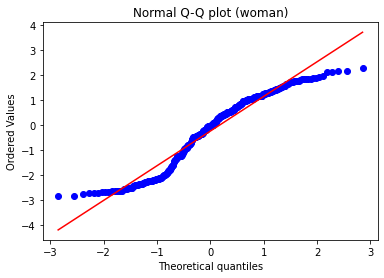

kolmogorv KstestResult(statistic=0.5726881398253764, pvalue=1.7526128011911975e-100)


In [61]:
check_normal_dist(df_NRC_woman, "arousal", "woman")

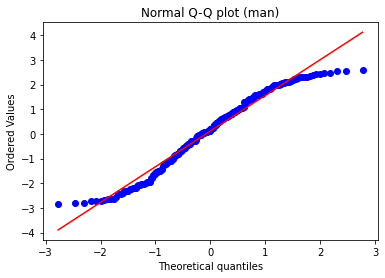

kolmogorv KstestResult(statistic=0.5729461058406172, pvalue=6.712907679917073e-78)


In [62]:
check_normal_dist(df_NRC_man, "arousal","man")

In [63]:
def apply_welch_test(df_1,df_2,score_type):
    from scipy.stats import ttest_ind
    import math
    import statistics
   
    stat, p = ttest_ind(df_1[score_type].tolist(),df_2[score_type].tolist(), nan_policy="omit", alternative="two-sided",equal_var=False )#, equal_var=False)
    alpha = 0.05
    print("Statistics=%3f, p=%.3f" % (stat, p))
    if p < alpha:
        print("Different distributions (reject H0)")
    else:
        print("Same distribution (fail to reject H0)")
    if p < alpha:
        d = (df_1[score_type].mean() - df_2[score_type].mean())/math.sqrt(((df_1[score_type].var() + df_2[score_type].var())/2))
        
        print(d, "Cohens D")
    print(len(df_1), len(df_2))

In [64]:
apply_welch_test(df_NRC_woman, df_NRC_man,"arousal")
apply_welch_test(df_NRC_woman, df_NRC_man,"valence")
apply_welch_test(df_NRC_woman, df_NRC_man,"dominance")

welsh
Statistics=1.227125, p=0.220
Same distribution (fail to reject H0)
322 249
welsh
Statistics=-2.043690, p=0.041
Different distributions (reject H0)
-0.1718216876635797 Cohens D
322 249
welsh
Statistics=-1.725864, p=0.085
Same distribution (fail to reject H0)
322 249


In [65]:
print(df_NRC_man["valence"].mean(),df_NRC_man["arousal"].mean(),df_NRC_man["dominance"].mean() )
print(df_NRC_woman["valence"].mean(),df_NRC_woman["arousal"].mean(),df_NRC_woman["dominance"].mean() )

0.5580481927710844 0.5379156626506023 0.5199518072289153
0.5131863354037266 0.5567018633540376 0.4942204968944104
